# 荷重減衰(weight decay)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.loss import mean_squared_error
from collections import OrderedDict
from common.layers import Affine, ReLU,MeanSquaredLoss, LeakyReLU
from common.optimizer import RMSProp, SGD

## 荷重減衰を考慮したニューラルネットワーク

### 損失関数
$\displaystyle L = L' + \frac{1}{2} \lambda \sum_{l=1}^{layers} \sum_{i, ~~j} (w_{ij}^{l})^2$    
  
$w_{i,j}^l$ : $l$層目の重み行列${\bf W}$の$i, j $成分   
$L$ : 正則化項を加えた後の損失    
$L'$ : 正則化項を加える前の損失    
$layers$ : 層番号    
$\lambda$ : 係数    
　　
### 重みの更新(SGDの場合)
$\displaystyle {\bf W}_{t+1} = {\bf W}_{t} - \eta (\frac{\partial L'}{\partial {\bf W}_t} + \lambda {\bf W}_{t})$   
  
$\bf W$ : 重み行列  
$L'$ : 正則化項を加える前の損失    
$\eta$ : 学習率    
$\lambda$ : 係数    

実装する際は、上記の更新を勾配の補正によって考慮するのが簡単でよい

### 勾配の補正
$\displaystyle \frac{\partial L}{\partial {\bf W}_t} = \frac{\partial L'}{\partial {\bf W}_t} + \lambda {\bf W}_{t}$    
  
$\bf W$ : 重み行列  
$L'$ : 正則化項を加える前の損失   
$\lambda$ : 係数    


### [演習]
* 以下の荷重減衰を取り入れたクラスを完成させましょう

In [2]:
# ヒント
W = np.array([[1,2,3],[4,5,6]])
print(np.sum(W**2))
print(np.sum(W*W))
print(np.linalg.norm(W)**2)

91
91
91.0


In [3]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01,
                            weight_decay_lambda=0.01):
        
        self.hidden_layer_num = 1
        self.weight_decay_lambda = weight_decay_lambda
        
        # 重みの初期化
        self.params = {}
        np.random.seed(1111)
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size) 
        self.params['b2'] = np.zeros(output_size)
        
        # レイヤの生成
        self.layers = OrderedDict() # 順番付きdict形式.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] =  ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = MeanSquaredLoss() # 出力層
        
    def predict(self, x):
        """
        推論関数
        x : 入力
        """
        for layer in self.layers.values():
            # 入力されたxを更新していく = 順伝播計算
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        """
        損失関数
        x:入力データ, t:教師データ
        """
        y = self.predict(x)
        
        # 荷重減衰を考慮した損失を求める
        lmd = self.weight_decay_lambda        
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            
            # 全ての行列Wについて、1/2* lambda * Σwij^2を求め、積算していく
            weight_decay += 0.5 * lmd * np.sum(W**2)

        return self.lastLayer.forward(y, t) + weight_decay
        
    def gradient(self, x, t):
        """
        全パラメータの勾配を計算
        """
        
        # 順伝播
        self.loss(x, t)

        # 逆伝播
        dout = self.lastLayer.backward(dout=1) # 出力層
        
        ## doutを逆向きに伝える 
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

            
        # 荷重減衰を考慮しながら、dW, dbをgradsにまとめる
        lmd = self.weight_decay_lambda
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + lmd * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
        return grads    

### データの生成

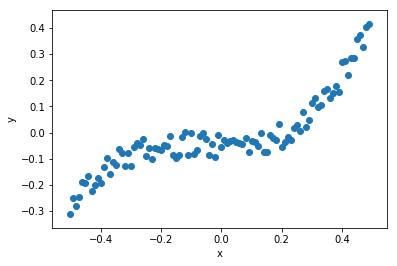

In [4]:
a = 3
b = 0.5
c = -0.1
x = np.arange(-0.5, 0.5, 0.01).reshape(1,-1)
error = np.random.rand(x.size) * 0.1
y = a * x**3 + b * x**2 + c + error
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### ミニバッチ学習

In [5]:
x = x.reshape(-1, 1)
t = y.reshape(-1, 1)

ecpochs = 5000
batch_size = 25
lr = 0.01

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# 2層NNのオブジェクト生成
tnet = TwoLayerNet(input_size=1, hidden_size=10, output_size=1, weight_init_std=0.01,
                                      weight_decay_lambda=0.001)

# 最適化手法
optimizer = RMSProp(lr=lr, rho=0.9)
    
# 初期パラメータの確認
print("初期パラメータ")
print(tnet.params["W1"].round(4))
print(tnet.params["b1"].round(4))
print(tnet.params["W2"].round(4))
print(tnet.params["b2"].round(4))


li_loss = []
for epoch in range(ecpochs):
    
    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        mask = idx[batch_size*it : batch_size*(it+1)]
    
        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]
        
        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = tnet.gradient(x_train, t_train)

        # パラメータの更新
        optimizer.update(tnet.params, grads)

    # 学習経過の記録
    loss = tnet.loss(x, t)
    li_loss.append(loss)

初期パラメータ
[[-0.013  -0.0107  0.0079 -0.0088  0.015  -0.0002  0.0028 -0.0097 -0.0158
  -0.002 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-0.0155]
 [-0.0039]
 [ 0.0109]
 [-0.0038]
 [-0.0094]
 [ 0.0041]
 [ 0.0136]
 [ 0.0138]
 [ 0.0067]
 [ 0.0017]]
[0.]


### 学習結果の確認

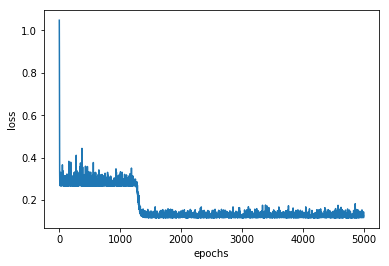

In [6]:
# lossのグラフ化
pd.DataFrame(li_loss).plot(legend=False)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

mse= 0.0011753155337847082


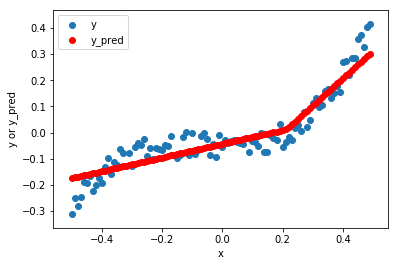

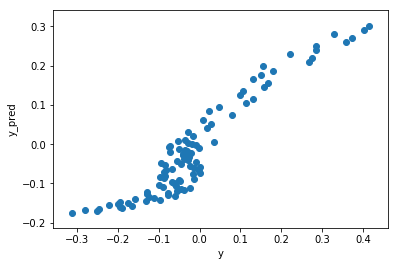

In [7]:
# 訓練精度の確認
y_pred = tnet.predict(x)
print("mse=",mean_squared_error(y_pred, t))


# 学習データと予測データの比較
plt.scatter(x, y )
plt.scatter(x, y_pred, color="r")
plt.xlabel("x")
plt.ylabel("y or y_pred")
plt.legend(["y","y_pred"])
plt.show()

# 学習データと予測データの比較
plt.scatter(y, y_pred)
plt.xlabel("y")
plt.ylabel("y_pred")
plt.show()

### [演習]
* weight_decay_lambdaを変更し、結果を比較してみましょう